In [517]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report

In [289]:
cases_text_onlyspeaker_df = pd.read_csv("cases_text_onlyspeaker.csv")
cases_text_onlyspeaker_df.head()

,new_name,sentence,sentence_clean,topic_mentioned,sentiment,prob_score_neg,prob_score_neutral,prob_score_pos,has_parking,has_econactivity,...,sent_voice_mentioned,sentpol_voice_mentioned,prob_pos_voice_mentioned,prob_neg_voice_mentioned,positive_voice_mentioned,negative_voice_mentioned,num_voice_mentioned,num_sentences,sentence_lower,count_my_name
0,09-12-2017audio_6ZA-2017-210-CU-1A,My name is Jerry Newman.,My name is Jerry Newman.,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,my name is jerry newman.,1
1,09-12-2017audio_6ZA-2017-210-CU-1A,"Thank you, President Chunkham, members of the ...","Thank you, President Chunkham, members of the ...",NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"thank you, president chunkham, members of the ...",0
2,09-12-2017audio_6ZA-2017-210-CU-1A,The question that is asked and that was asked ...,The question that is asked and that was asked ...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,the question that is asked and that was asked ...,0
3,09-12-2017audio_6ZA-2017-210-CU-1A,And I think Mr. Chang made an adequate descrip...,And I think Mr. Chang made an adequate descrip...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,and i think mr. chang made an adequate descrip...,0
4,09-12-2017audio_6ZA-2017-210-CU-1A,We started thinking through a business plan an...,We started thinking through a business plan an...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,we started thinking through a business plan an...,0


Load Sentence Embedding Model

In [290]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Get Embeddings

In [291]:
def get_embeddings(column):
  parking_rows = cases_text_onlyspeaker_df[cases_text_onlyspeaker_df[column] == 1]
  all_sentences = parking_rows["sentence"].tolist()
  
  return model.encode(all_sentences), all_sentences

Get Optimal k Clusters (Elbow Test)

In [292]:
def elbow_test(embeddings):
  inertias = []
  k_values = range(1, 20)

  for k in k_values:
      clustering_model = KMeans(n_clusters=k, random_state=0)
      clustering_model.fit(embeddings)
      inertias.append(clustering_model.inertia_)

  plt.figure(figsize=(8, 4))
  plt.plot(k_values, inertias, 'bo-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia (Sum of Squared Distances)')
  plt.title('Elbow Test for Optimal k')
  plt.grid(True)
  plt.show()

K-means Classifier

In [547]:
def get_labeled_sentences(label_file):
  labeled_sentences_df = pd.read_csv(label_file)
  labeled_sentences_ls = labeled_sentences_df["sentence"].tolist()
  labeled_sentences_embedded = model.encode(labeled_sentences_ls)

  return labeled_sentences_embedded

In [576]:
# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
#   clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#   clustering_model.fit(embeddings)
#   clusters = clustering_model.labels_

#   return clusters, clustering_model

#voting
# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10, test_embeddings=None):
#     n_samples = embeddings.shape[0]
#     all_clusters = np.zeros((n_init, n_samples), dtype=int)
#     all_models = []

#     # Run K-means multiple times and collect the cluster labels
#     for i in range(n_init):
#         clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i*100)
#         clustering_model.fit(embeddings)
#         all_clusters[i] = clustering_model.labels_
#         all_models.append(clustering_model)

#     # Perform voting (finding the most common cluster assignment for each observation)
#     final_clusters = mode(all_clusters, axis=0)[0].flatten()

#     # Fit the final model with the final clusters
#     final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#     final_clustering_model.fit(embeddings)
    
#     if test_embeddings is not None:
#         # Predict clusters for test set using voting
#         test_predictions = np.zeros((n_init, test_embeddings.shape[0]), dtype=int)
#         for i, model in enumerate(all_models):
#             test_predictions[i] = model.predict(test_embeddings)
        
#         final_test_predictions = mode(test_predictions, axis=0)[0].flatten()
#         return final_clusters, final_test_predictions
    
#     return final_clusters



# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
#     n_samples = embeddings.shape[0]
#     consensus_matrix = np.zeros((n_samples, n_samples))

#     # Run K-means with random initializations and update the consensus matrix
#     for i in range(n_init):
#         # K-Means with a different random seed each time for diverse initialization
#         clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i)
#         clustering_model.fit(embeddings)
#         clusters = clustering_model.labels_
        
#         # Update the consensus matrix
#         for j in range(n_samples):
#             for k in range(j + 1, n_samples):
#                 if clusters[j] == clusters[k]:
#                     consensus_matrix[j, k] += 1
#                     consensus_matrix[k, j] += 1

#     # Normalizing the consensus matrix
#     consensus_matrix /= n_init
    
#     # Final clustering using the consensus matrix
#     final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#     weighted_embeddings = np.dot(consensus_matrix, embeddings)
#     final_clustering_model.fit(weighted_embeddings)
#     final_clusters = final_clustering_model.labels_

#     return final_clusters, final_clustering_model


In [647]:
from scipy.spatial.distance import cdist

def match_clusters(centroids, reference_centroids):
    # Find the best match for each centroid in reference_centroids
    matches = []
    for centroid in centroids:
        distances = cdist([centroid], reference_centroids, 'euclidean')
        match = np.argmin(distances)
        matches.append(match)
    return matches

def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10, test_embeddings=None):
    n_samples = embeddings.shape[0]
    all_clusters = np.zeros((n_init, n_samples), dtype=int)
    all_models = []
    all_centroids = []

    # Run K-means multiple times and collect the cluster labels
    for i in range(n_init):
        clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i*100)
        clustering_model.fit(embeddings)
        all_clusters[i] = clustering_model.labels_
        all_models.append(clustering_model)
        all_centroids.append(clustering_model.cluster_centers_)

    # Use the centroids from the first run as the reference
    reference_centroids = all_centroids[0]

    # Align cluster labels across different runs
    aligned_clusters = np.zeros_like(all_clusters)
    aligned_clusters[0] = all_clusters[0]

    for i in range(1, n_init):
        matches = match_clusters(all_centroids[i], reference_centroids)
        aligned_clusters[i] = np.array([matches[label] for label in all_clusters[i]])

    # Perform voting (finding the most common cluster assignment for each observation)
    final_clusters = mode(aligned_clusters, axis=0)[0].flatten()

    # Fit the final model with the final clusters (optional)
    final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
    final_clustering_model.fit(embeddings)

    if test_embeddings is not None:
        # Predict clusters for test set using the aligned models
        test_predictions = np.zeros((n_init, test_embeddings.shape[0]), dtype=int)
        for i, model in enumerate(all_models):
            test_predictions[i] = model.predict(test_embeddings)
        
        # Align test set predictions according to the reference model
        aligned_test_predictions = np.zeros_like(test_predictions)
        aligned_test_predictions[0] = test_predictions[0]

        for i in range(1, n_init):
            matches = match_clusters(all_centroids[i], reference_centroids)
            aligned_test_predictions[i] = np.array([matches[label] for label in test_predictions[i]])

        # Perform voting on the aligned test predictions
        final_test_predictions = mode(aligned_test_predictions, axis=0)[0].flatten()
        return final_clusters, final_test_predictions
    
    return final_clusters

Visualize Clusters

In [294]:
def pca_plot(embeddings, clusters):
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(embeddings)

  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='rainbow', alpha=0.7)
  ax.view_init(elev=30, azim=120)


  ax.set_title('3D PCA of Sentence Embeddings with K-Means Clustering')
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')

  plt.colorbar(scatter, ax=ax, label='Cluster ID')
  plt.show()

In [295]:
def example_sentences(clustered_sentences, num_clusters, samples):
  for i in range(num_clusters):
      print(f"\nCluster {i}:")
      example_sentences = clustered_sentences[clustered_sentences['Cluster'] == i]['Sentence'].sample(samples)
      for sentence in example_sentences:
          print(f"- {sentence}")

In [296]:
def display_cluster_breakdown(clusters_df, cluster_labels):
  cluster_counts = clusters_df['Cluster'].value_counts().sort_index()
  total_sentences = cluster_counts.sum()

  cluster_data = []
  for cluster_num, count in cluster_counts.items():
      percentage = (count / total_sentences) * 100
      label = cluster_labels[cluster_num]
      cluster_data.append({
          'Cluster': cluster_num,
          'Pct of Sentences': f"{percentage:.2f}%",
          'Manual Guessed Label': label
      })

  cluster_breakdown_df = pd.DataFrame(cluster_data)
  cluster_breakdown_df.set_index('Cluster', inplace=True)

  return cluster_breakdown_df

Topic: Parking

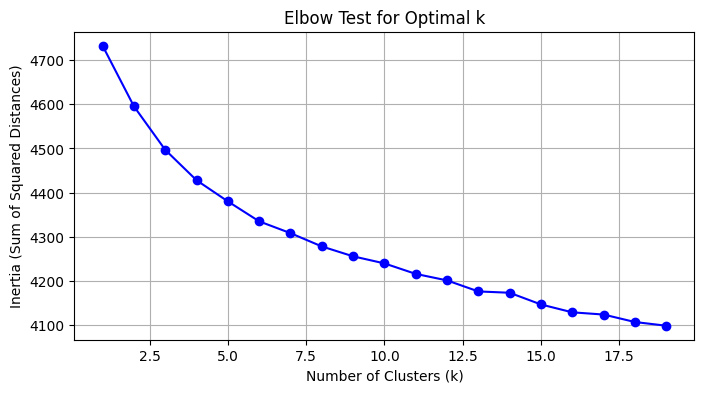

In [297]:
parking_embeddings, parking_sentences = get_embeddings('has_parking')
elbow_test(parking_embeddings)

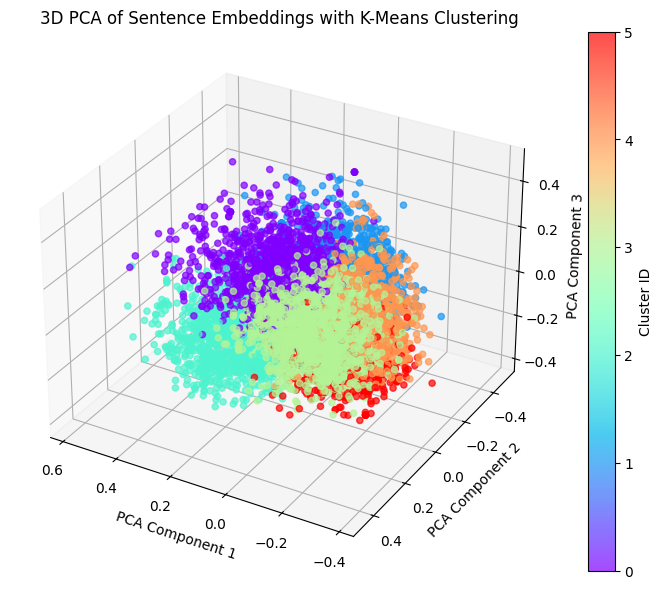

In [695]:
parking_num_clusters = 6

test_parking_sentences_embedded = get_labeled_sentences("labels/parking_labeled.csv")
parking_clusters, parking_pred = k_means_classifier(parking_embeddings, num_clusters=parking_num_clusters, seed=32, n_init=30, test_embeddings=test_parking_sentences_embedded)

parking_clusters_df = pd.DataFrame({'Sentence': parking_sentences, 'Cluster': parking_clusters})
pca_plot(parking_embeddings, parking_clusters)

In [696]:
parking_pred_ls = parking_pred.tolist()
print("lack parking")
print(parking_pred_ls[0:10])
print("parking relative to proposed project")
print(parking_pred_ls[10:15])
print(parking_pred_ls[15:19])
print("zoning, planning, beauracracy")
print(parking_pred_ls[19:27])
print(parking_pred_ls[25:])

lack parking
[4, 4, 4, 5, 3, 5, 5, 1, 5, 5]
parking relative to proposed project
[3, 0, 0, 0, 0]
[0, 1, 4, 4]
zoning, planning, beauracracy
[0, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 2, 0]


In [689]:
parking_example_sentences = 4
example_sentences(parking_clusters_df, parking_num_clusters, parking_example_sentences)


Cluster 0:
- Parking is an issue as well.
- We need more parking restrictions, not for who, the disabled.
- It also allows us to add more parking that accommodates and affect our full community.
- But still we come at 11 and wed be walking a long wayis to get to our house because theres just simply was no parking and youd walk people that were drunk, you know, not often, but enough to noticethat, and for me to be here, to tell you that its an issue.

Cluster 1:
- So we will provide monthly fees not to exceed 50 in the first year and then increased by 3 thereafter for people who wish to provide for at least 10 spaces for people who want to utilize parking right on a monthly basis.
- Okay, and then we have the parkingis based from a specific plan which is determined by the habitable room count.
- Let alone when they add, lets see, I think theyre adding about 400 or more parking places to this condo without any affordable housing in it.
- So now we have a five unit apartment with 11 park

In [697]:
parking_cluster_labels = {
    0: "parking relative to proposed project",
    1: "zoning, planning, beauracracy",
    2: " ",
    3: "",
    4: "",
    5: "lack of parking"
}



parking_cluster_breakdown_df = display_cluster_breakdown(parking_clusters_df, parking_cluster_labels)
parking_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,15.65%,parking relative to proposed project
1,18.11%,"zoning, planning, beauracracy"
2,14.42%,
3,20.60%,
4,19.46%,
5,11.75%,lack of parking


Topic: Nuisance

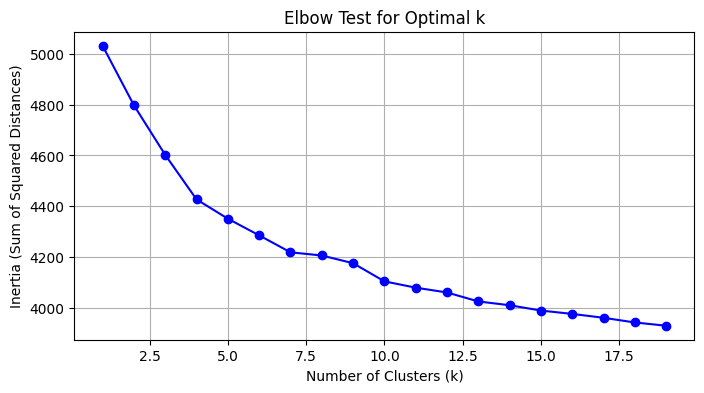

In [326]:
nuisance_embeddings, nuisance_sentences = get_embeddings('has_nuisance')
elbow_test(nuisance_embeddings)

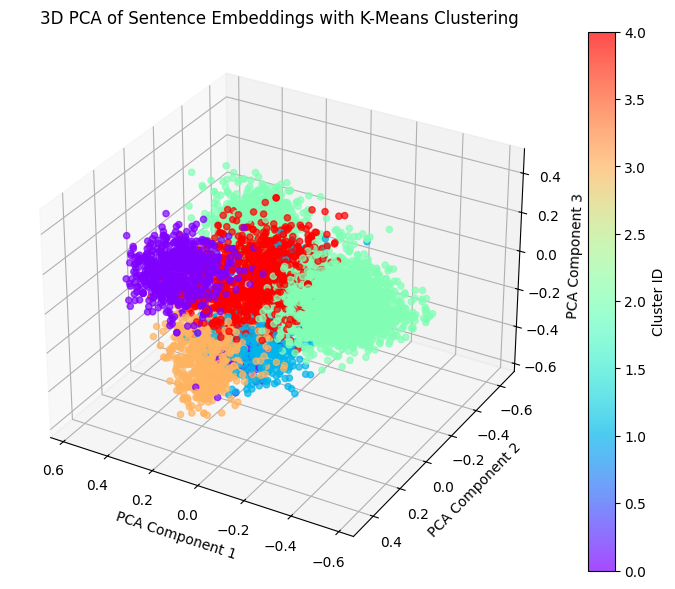

In [639]:
nuisance_num_clusters = 5

test_nuisance_sentences_embedded = get_labeled_sentences("labels/nuisance_labeled.csv")
nuisance_clusters, nuisance_pred = k_means_classifier(nuisance_embeddings, num_clusters=nuisance_num_clusters, seed=42, n_init=10, test_embeddings=test_nuisance_sentences_embedded)

nuisance_clusters_df = pd.DataFrame({'Sentence': nuisance_sentences, 'Cluster': nuisance_clusters})
pca_plot(nuisance_embeddings, nuisance_clusters)

In [646]:
nuisance_example_sentences = 4
example_sentences(nuisance_clusters_df, nuisance_num_clusters, nuisance_example_sentences)


Cluster 0:
- Im going to go ahead and additional open space available for the residences and on there its a tight roof because of the required open space that were providing as well as mechanical equipment that we did have some space to put some solar panels which they know is very important to environmental sustainability and just a few different renderings or images so you can seeon the design and also with regard to 40 LA the downtown plan for detail a 2040 we would be in the traditional core that document the community plan has not been updated.
- The South Park Business Improvement District has been added as a new recipient as a response to commissions concern about the reduction in open space requirements.
- The project will also include about 3677 square feet of open space.
- No, its simply part of the voluntary programming of the public open spaces for use for arts programming.

Cluster 1:
- I want to show you something that is very important and that is the relationship betwe

In [641]:
nuisance_cluster_labels = {
    0: "importance and management of open spaces",
    1: "traffic, local infrastructure",
    2: "noise, privacy",
    3: "security, crime",
    4: " "
}


nuisance_cluster_breakdown_df = display_cluster_breakdown(nuisance_clusters_df, nuisance_cluster_labels)
nuisance_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,11.88%,importance and management of open spaces
1,6.65%,"traffic, local infrastructure"
2,51.90%,"noise, privacy"
3,10.01%,"security, crime"
4,19.56%,


Topic: Affordable Housing

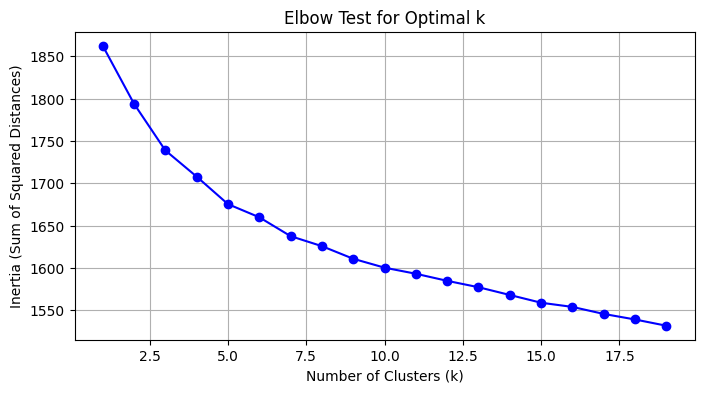

In [414]:
affordable_housing_embeddings, affordable_housing_sentences = get_embeddings('has_affordablehousing')
elbow_test(affordable_housing_embeddings)

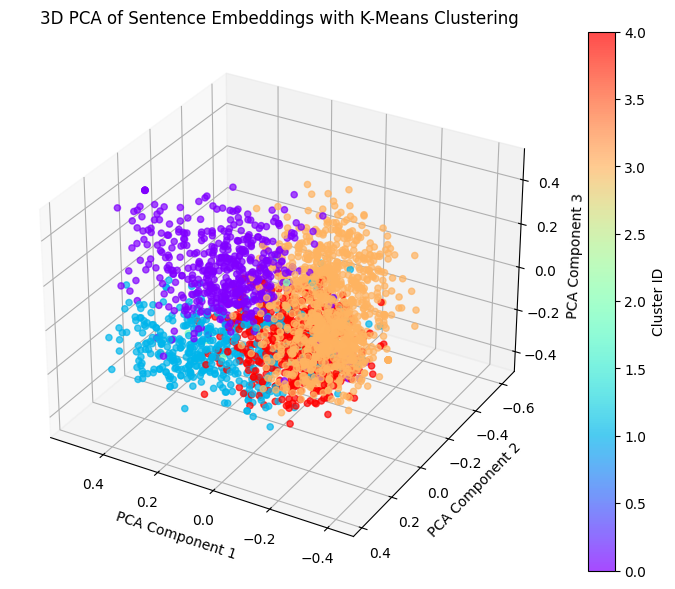

In [642]:
affordable_housing_num_clusters = 5

test_affordable_housing_sentences_embedded = get_labeled_sentences("labels/affordablehousing_labeled.csv")
affordable_housing_clusters, affordable_housing_pred = k_means_classifier(affordable_housing_embeddings, num_clusters=affordable_housing_num_clusters, seed=42, n_init=10, test_embeddings=test_affordable_housing_sentences_embedded)

affordable_housing_clusters_df = pd.DataFrame({'Sentence': affordable_housing_sentences, 'Cluster': affordable_housing_clusters})
pca_plot(affordable_housing_embeddings, affordable_housing_clusters)

In [546]:
affordable_housing_example_sentences = 6
example_sentences(affordable_housing_clusters_df, affordable_housing_num_clusters, affordable_housing_example_sentences)


Cluster 0:
- As you know, the TOC is a very important part of the projectsee program requires more affordability in tiers 2, 3 and 4.
- I too have concerns over the quantity or the percentage of the affordable housing units.
- Anybody can go there, rent a bike and go somewherereturn or return the bike in another family.
- And its also been really embraced by the neighbors who are really excited to have an affordable family-friendly restaurant in the area.
- It can be done, its expensive and time consuming, but we are dealing with the district here where I think just counting signalized is kind of one arm behind our back.
- And one of the levels being I support units for people for affordable housing.

Cluster 1:
- The project will add new rental units and set aside for very low affordable income renders.
- It does not give the proposed developer the added profits from putting its project on cheap residential land instead of expensive commercially-zoned land and offloading the costs of

In [698]:
affordable_housing_cluster_labels = {
    0: "cost, affordability",
    1: "cost/maintenance of providing affordable housing",
    2: "challenges to provide low-income units",
    3: "impact of loss of affordable housing",
    4: ""
}

# affordable_housing_cluster_labels = {
#     0: "challenges of providing affordable housing",
#     1: " ",
#     2: "impact of development on community",
#     3: "rent, tenant issues",
#     4: "cost, affordability"
# }


affordable_housing_cluster_breakdown_df = display_cluster_breakdown(affordable_housing_clusters_df, affordable_housing_cluster_labels)
affordable_housing_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,18.65%,"cost, affordability"
1,16.64%,cost/maintenance of providing affordable housing
2,0.41%,challenges to provide low-income units
3,41.50%,impact of loss of affordable housing
4,22.80%,


Topic: Neighborhood Character

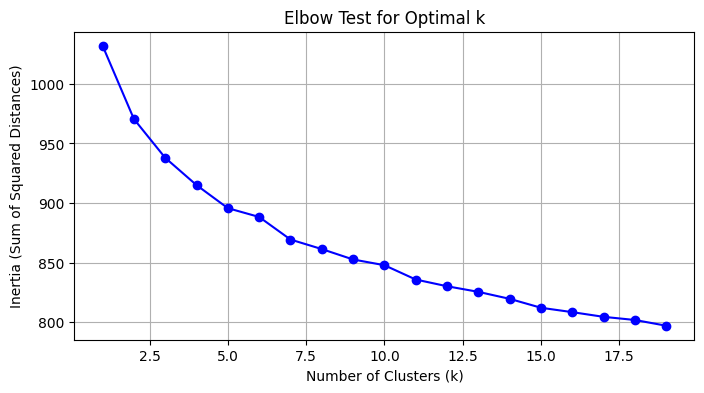

In [418]:
neighborhood_char_embeddings, neighborhood_char_sentences = get_embeddings('has_nhood_character')
elbow_test(neighborhood_char_embeddings)

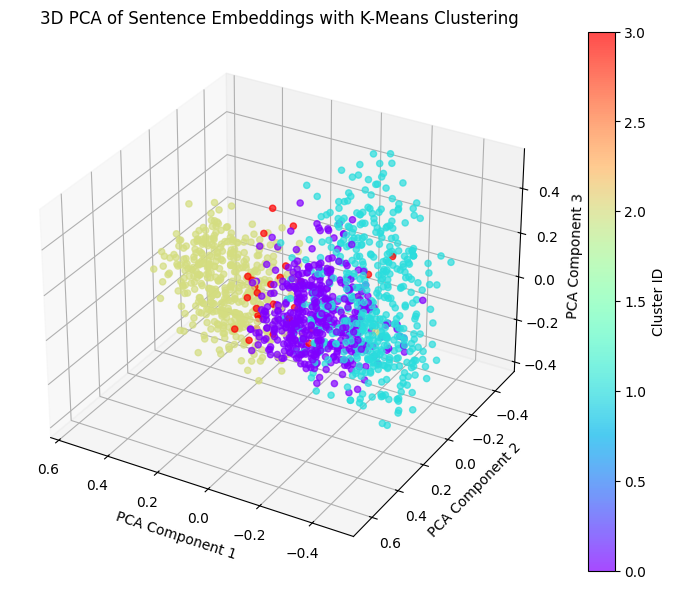

In [643]:
neighborhood_char_num_clusters = 4

test_neighborhood_char_sentences_embedded = get_labeled_sentences("labels/nhood_character_labeled.csv")
neighborhood_char_clusters, neighborhood_char_pred = k_means_classifier(neighborhood_char_embeddings, num_clusters=neighborhood_char_num_clusters, seed=42, n_init=10, test_embeddings=test_neighborhood_char_sentences_embedded)

neighborhood_char_clusters_df = pd.DataFrame({'Sentence': neighborhood_char_sentences, 'Cluster': neighborhood_char_clusters})
pca_plot(neighborhood_char_embeddings, neighborhood_char_clusters)

In [420]:
neighborhood_char_example_sentences = 4
example_sentences(neighborhood_char_clusters_df, neighborhood_char_num_clusters, neighborhood_char_example_sentences)


Cluster 0:
- We lose having more displacement.
- The thing is that we know for a fact also in Hollywood, the media studio, media district, the post-production studio, media district, a lot of displacement is occurring as a result of some of the more catalytic commercial retail developments.
- And in that situation for that entitlement, we do look at the at community character.
- The Deputy Advisory Agency used its discretion to opt for the former, as it tends to do councilmember kurets encourages this commission to opt for the preservation of affordability which is equally within your discretion.

Cluster 1:
- So as I started to say before, we just like to take a minute to thank the applicant for working with the community, the neighborhood council, the preservation community, the neighbors.
- Obviously, neighborhood character premise size is very important, obviously in some areas we might have a block thats broken up into 10 stores, maybe there are 5,000 or 2,000 square feet each, m

In [421]:
neighborhood_char_cluster_labels = {
    0: " ",
    1: "historical preservation",
    2: "concern about development impacts on existing properties",
    3: "concern about lack of neighborhood character on residential properties"
}


neighborhood_char_cluster_breakdown_df = display_cluster_breakdown(neighborhood_char_clusters_df, neighborhood_char_cluster_labels)
neighborhood_char_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,15.94%,
1,43.60%,historical preservation
2,39.37%,concern about development impacts on existing ...
3,1.09%,concern about lack of neighborhood character o...


accuracy

In [624]:
def get_true_labels(label_file):
  labeled_sentences_df = pd.read_csv(label_file)
  # labeled_sentences_ls = labeled_sentences_df["sentence"].tolist()
  true_labels_ls = labeled_sentences_df["label"].tolist()

  # # labeled_sentences_embedded = model.encode(labeled_sentences_ls)
  # pred_labels = kmeans_model.predict(labeled_sentences_embedded)
  # pred_labels_ls = pred_labels.tolist()

  # pred_labels_ls = [9 if label not in other_labels else label for label in pred_labels_ls]
  
  return true_labels_ls


In [558]:
def get_accuracy_scores(true_labels, pred_labels):
  accuracy = accuracy_score(true_labels, pred_labels)

  report = classification_report(true_labels, pred_labels, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df = report_df.round(2)  # Round to 2 decimal places for better readability

  return accuracy, report_df

In [655]:
parking_not_other = {0,1,5}
parking_true = get_true_labels("labels/parking_labeled.csv")
parking_pred_edited = [9 if label not in parking_not_other else label for label in parking_pred]


parking_accuracy, parking_report_df = get_accuracy_scores(parking_true, parking_pred_edited)

print(f"Parking Accuracy: {parking_accuracy:.2f}")
parking_report_df

Parking Accuracy: 0.32


,precision,recall,f1-score,support
1,0.00,0.00,0.00,8.00
4,0.00,0.00,0.00,5.00
5,0.00,0.00,0.00,10.00
9,0.48,0.59,0.53,27.00
accuracy,0.32,0.32,0.32,0.32
macro avg,0.12,0.15,0.13,50.00
weighted avg,0.26,0.32,0.29,50.00


In [568]:
len(parking_pred)

50

In [538]:
nuisance_not_other = {0,1,2,3,4}
nuisance_true, nuisance_pred = get_true_pred_labels("labels/nuisance_labeled.csv", nuisance_clustering_model, nuisance_not_other)

nuisance_accuracy, nuisance_report_df = get_accuracy_scores(nuisance_true, nuisance_pred)

print(f"Nuisance Accuracy: {nuisance_accuracy:.2f}")
nuisance_report_df

Nuisance Accuracy: 0.82


,precision,recall,f1-score,support
0,1.00,1.00,1.00,7.00
1,1.00,0.79,0.88,19.00
2,1.00,0.91,0.95,11.00
3,0.80,0.80,0.80,10.00
4,0.12,0.33,0.18,3.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.78,0.77,0.76,50.00
weighted avg,0.91,0.82,0.86,50.00


In [540]:
label_file = "labels/affordablehousing_labeled.csv"
labeled_sentences_df = pd.read_csv(label_file)
labeled_sentences_ls = labeled_sentences_df["sentence"].tolist()
true_labels_ls = labeled_sentences_df["label"].tolist()

labeled_sentences_embedded = model.encode(labeled_sentences_ls)
pred_labels = affordable_housing_clustering_model.predict(labeled_sentences_embedded)
pred_labels_ls = pred_labels.tolist()

pred_labels

array([1, 3, 2, 0, 0, 3, 2, 1, 2, 3, 0, 2, 0, 3, 3, 2, 0, 0, 0, 1, 3, 0,
       0, 2, 4, 4, 0, 4, 1, 0], dtype=int32)